When describing the relevant aspects of the data, and any other datasets you may intend to use, you should in particular show (non-exhaustive list):

1) That you can handle the data in its size.
2) That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
3) That you considered ways to enrich, filter, transform the data according to your needs.
4) That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
5) That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

We will evaluate this milestone according to how well these steps have been done and documented, the quality of the code and its documentation, the feasibility and critical awareness of the project. We will also evaluate this milestone according to how clear, reasonable, and well thought-through the project idea is. Please use the second milestone to really check with us that everything is in order with your project (idea, feasibility, etc.) before you advance too much with the final Milestone P3! There will be project office hours dedicated to helping you.

# Modules and tools :

In [98]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from datetime import datetime, date, time
import requests

# Beer dataset:

The dataset come from two different websites : https://www.ratebeer.com/ and https://www.beeradvocate.com/. This two platform where one can review and share about beers. Technically it consists of three csv files and two txt files for each websites :
1) beers.csv : informations about the beers
2) breweries.csv : informations about the breweries
3) users.csv : informations about the users
4) rating.txt : all the different rating for each beer
5) reviews.txt : all the different review for each beer

There is also matched dataset between the two websites.

### Lets take a look at the data given by BeerAdvocate :

In [14]:
beers_ba = pd.read_csv('DATA/BeerAdvocate/beers.csv')
beers_ba.head(10)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
5,166068,Arpa,39913,Arpa (АРПА),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
6,166071,Eles,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
7,166072,Eles Light,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,3.2,NaN,NaN,0,NaN
8,166074,Toroz Svetloye,39914,Bear Beer,American Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
9,166076,Toroz Temnoye,39914,Bear Beer,Euro Dark Lager,0,0,NaN,NaN,NaN,4.1,NaN,NaN,0,NaN


In [11]:
breweries_ba = pd.read_csv('DATA/BeerAdvocate/breweries.csv')
breweries_ba.head(10)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
5,16051,Kyrgyzstan,Pivzavod Uzgen,0
6,16052,Kyrgyzstan,Steinbrau Pub,4
7,39917,Kyrgyzstan,Usu-Salkin Pivo,3
8,37262,Gabon,Societe des Brasseries du Gabon (SOBRAGA),1
9,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5


As we can see it seems that the data are stored in a relational model (i.e., the index ```brewery_id``` in the beers.csv dataset is the foreign key that point to the primary key ```id``` in the breweries.csv. 

We can confirm our observation with a prelimenary check on the name of the brewery for the first row of ```beer_ba```: 

In [27]:
beers_ba.iloc[0].brewery_name == breweries_ba[breweries_ba.id == beers_ba.iloc[0].brewery_id].name

0    True
Name: name, dtype: bool


Ok so we have our first confirmation, we should make sure that there is no problem with the attribution of the key by performing the test for each rows but for now let assume there is no issues.

Let's first dicuss about the data size.

## Relationship between user's country and beer origin

Let's have a look at possible indicators that may suggest correlations between the users country and the beers they review and prefer.

In this initial exploration, we are going to use a sampled version of the data of reviews from the BeerAdvocate source. This sample file encompass the first 2,000,000 lines from the original text file (of more than 151 million lines). 

In [5]:
# The datasets' location in the repository:

sample_file = 'datasets/BeerAdvocate/reviews_sample.txt'
users_file = 'datasets/BeerAdvocate/users.csv'
breweries_file = 'datasets/BeerAdvocate/breweries.csv'

#### Functions to read the datasets:

In [48]:
def parse_dict(lines):
    result = {}
    for line in lines:
        key, value = line.split(':', 1)
        value = value.split('\n')[0]
        result[key] = value
    return result


def read_reviews_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    blank_lines_indexes = [index for index, line in enumerate(lines) if line.isspace()]

    data = []
    begin_index = 0
    for end_index in blank_lines_indexes:
        result_dict = parse_dict(lines[begin_index:end_index])
        data.append(result_dict)
        begin_index = end_index + 1

    df = pd.DataFrame(data)
    for field in ['user_id', 'style']:
        df[field] = df[field].apply(lambda x: x.strip())
    df['brewery_id'] = df['brewery_id'].astype(int)
    df['rating'] = df['rating'].astype(float)
    return df


def read_users_file(users_file):
    df = pd.read_csv(users_file).dropna()
    df['user_id'] = df['user_id'].apply(lambda x: x.strip())
    df['country'] = df['location'].apply(lambda x: x.split(',', 1)[0].lower())
    return df


def read_breweries_file(file_path):
    df = pd.read_csv(file_path).dropna()
    df['country'] = df['location'].apply(lambda x: x.split(',', 1)[0].lower())
    df['id'] = df['id'].astype(int)
    return df

### The dataset of reviews:

In [16]:
reviews_df = read_reviews_file(file_path=sample_file)
print(f'number of reviews = {len(reviews_df)}')
reviews_df.head(1)

number of reviews = 111111


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True


### The dataset of users:

In [27]:
users_df = read_users_file(users_file)
print(f'Number of users = {len(users_df)}')
users_df.head(1)

Number of users = 122424


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,country
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",united states


In [28]:
users_country_list = list(users_df.country.unique())
print(f'Number of different contries form users = {len(users_country_list)}')

Number of different contries form users = 145


Storing the users' origin in a dictionary

In [35]:
users_contry_dict = dict(zip(users_df.user_id, users_df.country))

### The dataset of breweries:

In [30]:
breweries_df = read_breweries_file(breweries_file)
print(f'Number of breweries = {len(breweries_df)}')
breweries_df.head(1)

Number of breweries = 16758


,id,location,name,nbr_beers,country
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,kyrgyzstan


In [31]:
print(f'Number of different contries from breweries = {len(list(breweries_df.country.unique()))}')

Number of different contries from breweries = 236


Storing the breweries' origin in a dictionary

In [ ]:
breweries_contry_dict = dict(zip(breweries_df.id, breweries_df.country))

### Combining reviews, users and breweries:

For each review, we will check if the origin of the user (reviewer) is the same as the brewery (whose beer is being reviewed), marking it with a `1` if the contries match and `0` otherwise.

Merging users and breweries origin (filtering out cases where location in unknown):

In [36]:
def get_country(id, correspondance_dict):
    if id in correspondance_dict:
        return correspondance_dict[id]
    else:
        return np.nan

reviews_df['user_country'] = reviews_df['user_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=users_contry_dict)
)
reviews_df['brewery_country'] = reviews_df['brewery_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=breweries_contry_dict)
)
reviews_df = reviews_df.dropna()

Creating a column to store if country is the same:

In [38]:
def is_contry_the_same(contry1, country2):
    if contry1==country2: 
        return 1
    else:
        return 0

reviews_df['is_same_country'] = reviews_df.apply(lambda row: is_contry_the_same(row.user_country, row.brewery_country), axis=1)

To check if the difference in origin between the user and beer is statistically significant across reviews, we will compute the 95% confidence intervals (using `scipy.stats`) of the generated column `is_same_country`:

In [62]:
def get_confidence_interval(data, title=None):
    interval = st.t.interval(confidence=0.95,
                df=len(data)-1,
                loc=np.mean(data), 
                scale=st.sem(data))
    print('--------------------------')
    if title:
        print(title)
    print()
    print(f'''Average = {np.mean(data)}
Confidence interval = {interval}''')
    print('--------------------------')
    return interval


interval = get_confidence_interval(list(reviews_df.is_same_country), "Comparison between user and beer origin from all reviews:")

--------------------------
Comparison between user and beer origin from all reviews:

Average = 0.06246369773664315
Confidence interval = (0.06100008904155203, 0.06392730643173426)
--------------------------


This result indicates that, in general, for all reviews, the country of the user (reviewer) tend to not be the same as the beer being reviewed. In fact, this would be expected, as the probability of any given country being one's (unique) contry of origin is very low, given that there are many more countries which are not this person's country.

What we want to investigate further here is the user's *preference* as a function of contry, which can be hidden inside the gross number of reviews. 

## Metrics to capture user's preference

Some initial ideias to capture the users preferences are related to analyzing what are the styles and contries of origin of each person's most frequent reviews, as well as the individual's best rated reviews. 

This type of analysis can be done with the following function, which we intend to develop and build upon in the third phase of the project:

In [85]:
def get_user_preferences_df(reviews_df, number_of_reviews_threshold=5):
    grouped = reviews_df.groupby('user_id')
    data = []
    for user_id, group in grouped:
        if len(group) >= number_of_reviews_threshold:
            row_dict = {}
            row_dict['user_id'] = user_id
            row_dict['user_country'] = users_contry_dict[user_id]

            most_frequent_style = group['style'].value_counts().idxmax()
            row_dict['most_frequent_style'] = most_frequent_style

            most_frequent_country = group['brewery_country'].value_counts().idxmax()
            row_dict['most_frequent_country'] = most_frequent_country

            highest_rated_index = group['rating'].idxmax()
            highest_rated_beer = reviews_df.loc[highest_rated_index]
            row_dict['highest_rating'] = highest_rated_beer.rating
            row_dict['highest_rated_origin'] = highest_rated_beer.brewery_country

            row_dict['is_country_same_as_highest_rated'] = 1 if highest_rated_beer.brewery_country == users_contry_dict[user_id] else 0
            row_dict['is_country_same_as_most_frequent'] = 1 if most_frequent_country == users_contry_dict[user_id] else 0

            avg_rating_per_style = group.groupby(['style'])['rating'].mean().to_dict()
            row_dict['highest_rated_style'] = max(avg_rating_per_style, key=avg_rating_per_style.get)
            row_dict['lowest_rated_style'] = min(avg_rating_per_style, key=avg_rating_per_style.get)

            # row_dict['favorite_beers_avg_rating'] = group[group['style'] == most_frequent_style]['rating'].mean()
            # row_dict['other_beers_avg_rating'] = group[group['style'] != most_frequent_style]['rating'].mean()

            data.append(row_dict)
    return pd.DataFrame(data)

In order to have a solid grasp of each individuals preferences, we decided to consider individuals with at the number of least $n$ different ratings. (Although this can reduce the number of instances in  our analysis, it makes the estimation of the user's preferences more robust).

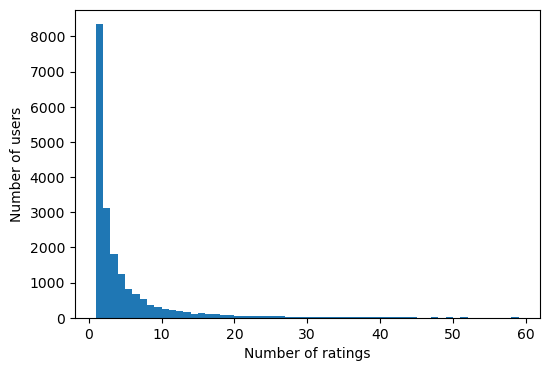

In [88]:
fig = plt.figure().set_size_inches(6,4)
number_of_reviews = reviews_df.value_counts('user_id').values
bins = np.arange(1, 60, 1)
plt.ylabel('Number of users')
plt.xlabel('Number of ratings')
plt.hist(number_of_reviews, bins=bins)
plt.show()

Here, we would like compare how the most reviewed country for each individual and the origin of her/his highest rated beer relates to its own country. For this reason, we compute the average values and confidence intervals for both the `is_country_same_as_highest_rated` and `is_country_same_as_most_frequent` fields generated below.

In [89]:
user_prefs_df = get_user_preferences_df(reviews_df)

In [90]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_most_frequent), "Comparison between user and beer origin for most frequent beer country:")

--------------------------
Comparison between user and beer origin for most frequent beer country:

Average = 0.024041327240214582
Confidence interval = (0.01980804540404256, 0.028274609076386605)
--------------------------


In [91]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_highest_rated), "Comparison between user and beer origin for highest rated review:")

--------------------------
Comparison between user and beer origin for highest rated review:

Average = 0.019074110868269423
Confidence interval = (0.015293843659853626, 0.022854378076685222)
--------------------------


As it can be observed in this preliminary analysis, the average value of the most frequent beer country is higher than the country of the highest reviews for each individual. This can point to a be subtle trend for the users reviewing on average more beers from their own country, but not necessarly having these beers as their favorite (they can be from a different country).

Improved versions of these type of analysis are planned to be made in the third part of the project, accounting for all ratings from both beer reviews websites. Among other things, further care will be taken to analysis cases where 
inherant imbalances in the dataset between beers and reviews may affect the final results and conclusions 

## Examples of illustrative analysis

Beyond computing metrics, we plan to make interactive visualizations of the preffered beers across styles and countries around the world, in a way that may support our insights from the data generated. Some premature examples relate the user's country of origin and beer style as follows:

In [96]:
def get_beer_style_matrix(df, category, n_most_frequent=10):
    new_df = df[['user_country', category]].copy()
    most_frequent_countries = list(new_df['user_country'].value_counts()[:n_most_frequent].keys())
    most_frequent_styles = list(new_df[category].value_counts()[:n_most_frequent].keys())

    new_df.user_country = new_df.user_country.astype("category")
    new_df.user_country = new_df.user_country.cat.set_categories(most_frequent_countries)
    new_df.sort_values(['user_country'])
    
    new_df[category] = new_df[category].astype("category")
    new_df[category] = new_df[category].cat.set_categories(most_frequent_styles)
    new_df.sort_values([category])

    new_df = new_df[new_df['user_country'].isin(most_frequent_countries)]
    new_df = new_df[new_df[category].isin(most_frequent_styles)]
    new_df['count'] = 1
    new_df = pd.pivot_table(new_df, values=['count'], index=['user_country'],
                        columns=[category], aggfunc=np.sum, fill_value=0)
    return new_df['count']

Text(0.5, 1.0, "Beer preferences across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 10 countries and styles)")

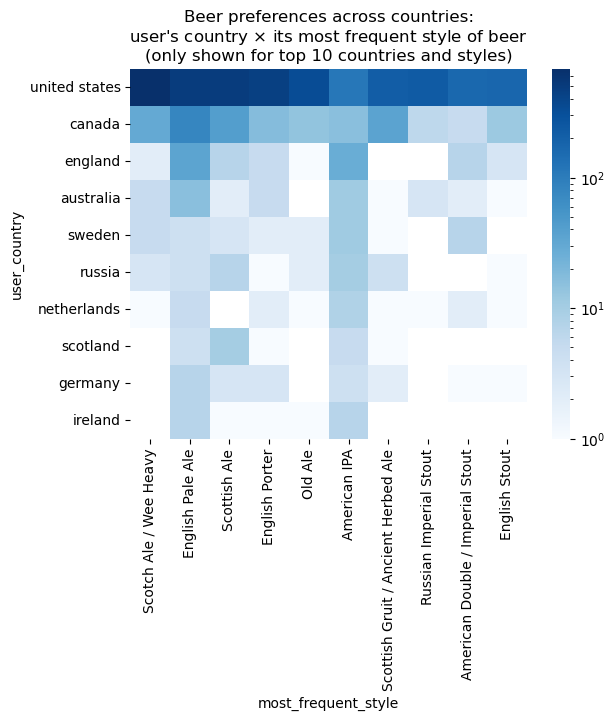

In [105]:
most_frequent_df = get_beer_style_matrix(
    df=user_prefs_df,
    category='most_frequent_style'
)
sns.heatmap(most_frequent_df, cmap="Blues", norm=LogNorm())

plt.title('''Beer preferences across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top 10 countries and styles)''')

Future (improved) versions of these plots are expected to account for clever ways to fit more countries in a concise plot, as well as normalize the user's preferences by taking into account the unequal distribution of users across countries. 